# Generative Adverserial Network for Fake Image Generation

In this Notebook, we will train an FC-GAN to genereate fake Mnist data.

Followed by a conversion of the FC-GAN to DC-GAN, and the generation of higher resolution images.

Gan Paper: https://arxiv.org/abs/1406.2661

PyTorch MNist dataset : https://pytorch.org/docs/stable/torchvision/datasets.html#mnist

Convert FC-Gan To DC-Gan Paper : https://arxiv.org/pdf/1511.06434.pdf

List of tricks to train GANs: https://github.com/soumith/ganhacks

In [1]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.utils as vutils
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [25]:
# Root directory for dataset
dataroot = "./df"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 50

# Learning rate for optimizers
lr = 0.0003

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1


In [26]:
def load_mnist_minibatched(batch_size: int, n_train: int = 8192, n_valid: int = 1024,
                           valid_test_batch_size: int = 1024):
    transform = transforms.Compose([transforms.Scale(64),
                                transforms.ToTensor()])
    train_dataset = torchvision.datasets.MNIST(
        root='../data', train=True, transform=transform, download=True)
    test_dataset = torchvision.datasets.MNIST(
        root='../data', train=False, transform=transform)

    train_sampler = SubsetRandomSampler(range(n_train))
    validation_sampler = SubsetRandomSampler(range(n_train, n_train+n_valid))

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, sampler=train_sampler)
    validation_loader = DataLoader(dataset=train_dataset, batch_size=valid_test_batch_size,
                                   sampler=validation_sampler)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=valid_test_batch_size, 
                                              shuffle=False)
    return train_loader, validation_loader, test_loader

torch.Size([128, 1, 64, 64])


/home/bb/deep/lib/python3.8/site-packages/torchvision/transforms/transforms.py:219: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


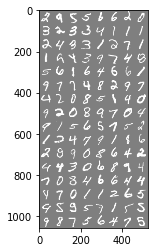

    2     9     5     5


In [27]:
dataloader, validation_loader, test_loader = load_mnist_minibatched(batch_size)

# get some random training images
dataiter = iter(dataloader)
images, labels = dataiter.next()

print(images.shape)
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

img = torchvision.utils.make_grid(images)

# show images
img = img / 2 + 0.5     # unnormalize
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

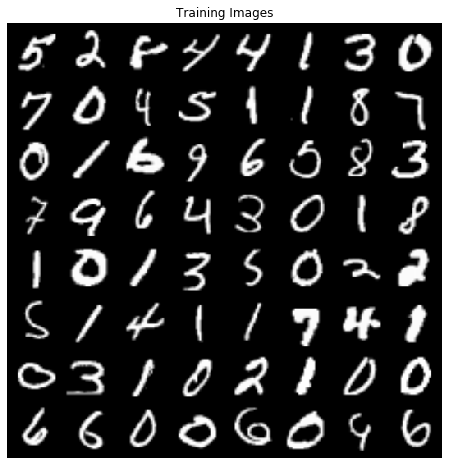

In [28]:


# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [29]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [30]:
# The Generative Network

class Generator(nn.Module):
    """
        The CNN convolutional network with architecture defined above
    """
    def __init__(self, ngpu):
        super().__init__()
        
        self.ngpu = ngpu
        
        self.fc1 = nn.Linear(in_features= 100, out_features=6 * 6)
        
        self.fc2 = nn.Linear(in_features= 6 * 6, out_features=12 * 12)
        
        self.bn2 = nn.BatchNorm1d(12*12)
        
        self.fc3 = nn.Linear(in_features= 12 * 12, out_features=24 * 24)
        
        self.bn3 = nn.BatchNorm1d(24*24)
        
        self.fc4 = nn.Linear(in_features= 24 * 24, out_features=32 * 32)
        
        self.bn4 = nn.BatchNorm1d(32*32)
        
        self.fc5 = nn.Linear(in_features= 32 * 32, out_features=46 * 46)
        
        self.fc6 = nn .Linear(in_features= 46 * 46, out_features=64 * 64)
        
        self.LeakyReLU = nn.LeakyReLU()
        
        self.tanh = nn.Tanh()

    def forward(self, x):
        """
        
        Args:
            x: The input tensor with shape [batch_size, feature_dim] (minibatch of data)
        Returns:
            scores: Pytorch tensor of shape (N, C) giving classification scores for x
        """
        x = self.fc1(x)
        x = self.LeakyReLU(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.LeakyReLU(x)
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.LeakyReLU(x)
        x = self.fc4(x)
        x = self.bn4(x)
        x = self.LeakyReLU(x)
        x = self.fc5(x)
        x = self.LeakyReLU(x)
        x = self.fc6(x)
        return self.tanh(x)

In [31]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
#netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (fc1): Linear(in_features=100, out_features=36, bias=True)
  (fc2): Linear(in_features=36, out_features=144, bias=True)
  (bn2): BatchNorm1d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=144, out_features=576, bias=True)
  (bn3): BatchNorm1d(576, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=576, out_features=1024, bias=True)
  (bn4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc5): Linear(in_features=1024, out_features=2116, bias=True)
  (fc6): Linear(in_features=2116, out_features=4096, bias=True)
  (LeakyReLU): LeakyReLU(negative_slope=0.01)
  (tanh): Tanh()
)


In [32]:
class Discriminator(nn.Module):
    """
        The CNN convolutional network with architecture defined above
    """
    def __init__(self, ngpu):
        super().__init__()
        
        self.ngpu = ngpu
        
        self.fc1 = nn .Linear(in_features= 64 * 64, out_features=46 * 46)
        
        self.fc2 = nn.Linear(in_features= 46 * 46, out_features=32 * 32)
        
        self.fc3 = nn.Linear(in_features= 32 * 32, out_features=22 * 22)
        
        self.fc4 = nn.Linear(in_features= 22 * 22, out_features=12 * 12)
        
        self.fc5 = nn.Linear(in_features= 12 * 12, out_features=6 * 6)
        
        self.fc6 = nn.Linear(in_features= 6 * 6, out_features=1)
        
        self.LeakyReLU = nn.LeakyReLU()
        
        self.sig = nn.Sigmoid()
        
        self.drop = nn.Dropout(p=0.5)
        
        
    def forward(self, x):
        """
        Args:
            x: The input tensor with shape [batch_size, feature_dim] (minibatch of data)
        Returns:
            scores: Pytorch tensor of shape (N, C) giving classification scores for x
        """
        
        x = x.view(x.shape[0], 64 * 64)
    
        x = self.fc1(x)
        x = self.LeakyReLU(x)
        x = self.fc2(x)
        x = self.drop(x)
        x = self.LeakyReLU(x)
        x = self.fc3(x)
        x = self.LeakyReLU(x)
        x = self.fc4(x)
        x = self.drop(x)
        x = self.LeakyReLU(x)
        x = self.fc5(x)
        x = self.LeakyReLU(x)
        x = self.fc6(x)
        return self.sig(x)

In [33]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
#netD.apply(weights_init)

# Print the model
print(netD)


Discriminator(
  (fc1): Linear(in_features=4096, out_features=2116, bias=True)
  (fc2): Linear(in_features=2116, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=484, bias=True)
  (fc4): Linear(in_features=484, out_features=144, bias=True)
  (fc5): Linear(in_features=144, out_features=36, bias=True)
  (fc6): Linear(in_features=36, out_features=1, bias=True)
  (LeakyReLU): LeakyReLU(negative_slope=0.01)
  (sig): Sigmoid()
  (drop): Dropout(p=0.5, inplace=False)
)


In [34]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [35]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # print(label.shape)
        # Forward pass real batch through D
        output = netD(real_cpu)#.view(-1)
        # print(output.shape)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach())#.view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
                fake = fake.view(fake.shape[0],1, 64, 64)
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/50][0/64]	Loss_D: 1.3878	Loss_G: 0.6785	D(x): 0.5112	D(G(z)): 0.5117 / 0.5074


/home/bb/deep/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[0/50][50/64]	Loss_D: 1.4054	Loss_G: 0.6573	D(x): 0.5102	D(G(z)): 0.5189 / 0.5182
[1/50][0/64]	Loss_D: 1.4238	Loss_G: 0.6492	D(x): 0.5117	D(G(z)): 0.5289 / 0.5226
[1/50][50/64]	Loss_D: 1.3577	Loss_G: 0.8124	D(x): 0.5368	D(G(z)): 0.5194 / 0.4451
[2/50][0/64]	Loss_D: 1.2940	Loss_G: 0.9404	D(x): 0.5337	D(G(z)): 0.4841 / 0.3928
[2/50][50/64]	Loss_D: 1.0373	Loss_G: 1.4743	D(x): 0.7630	D(G(z)): 0.5190 / 0.2549
[3/50][0/64]	Loss_D: 0.4507	Loss_G: 6.5539	D(x): 0.7201	D(G(z)): 0.1067 / 0.0071
[3/50][50/64]	Loss_D: 0.6419	Loss_G: 2.5800	D(x): 0.7933	D(G(z)): 0.3064 / 0.1220
[4/50][0/64]	Loss_D: 0.7606	Loss_G: 3.0675	D(x): 0.7364	D(G(z)): 0.3000 / 0.1273
[4/50][50/64]	Loss_D: 0.3692	Loss_G: 3.7864	D(x): 0.8634	D(G(z)): 0.1633 / 0.0383
[5/50][0/64]	Loss_D: 0.2582	Loss_G: 6.8078	D(x): 0.9110	D(G(z)): 0.1095 / 0.0143
[5/50][50/64]	Loss_D: 0.9463	Loss_G: 1.0876	D(x): 0.7403	D(G(z)): 0.4517 / 0.3474
[6/50][0/64]	Loss_D: 0.8196	Loss_G: 1.6700	D(x): 0.7170	D(G(z)): 0.2872 / 0.2095
[6/50][50/64]	Loss_D: 

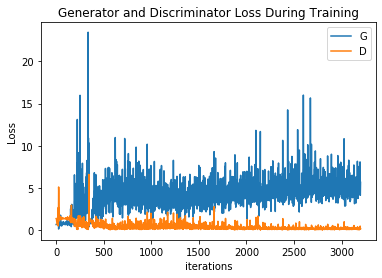

In [36]:
##### plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

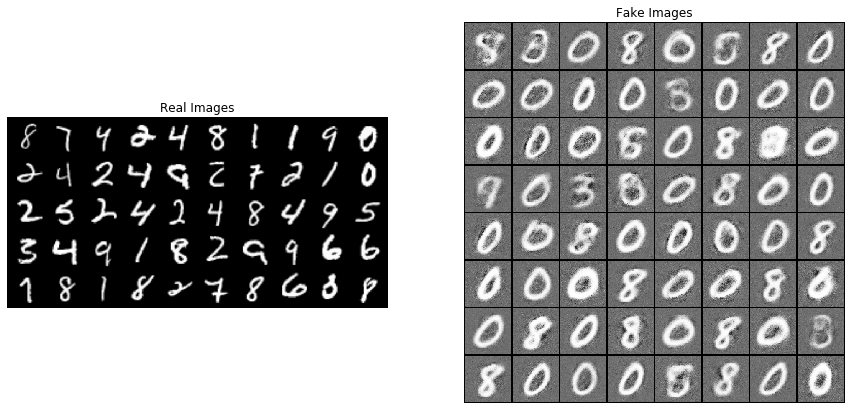

In [38]:


# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:50], padding=5, nrow=10, normalize=True).cpu(),(1,2,0)), cmap='viridis')

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()